# Overview and references

You will use the provided sequencing reads from a Ribo-seq experiment in Saccharomyces cerevisiae to generate a plot that shows the density of ribosomes along an mRNA sequence. You will perform the following steps

1. Filter the reads for ncRNA and rRNA sequences 
2. Use bowtie2 for the alignments 
3. Use Python to analyze the SAM file
4. Use Python to plot the results.


You are expected to keep a thorough record of everything you did in your notebook.


Data from [Weinberg et al (2016)](https://pubmed.ncbi.nlm.nih.gov/26876183/). Workflow courtesy of Lareau lab.

The repo contains three bowtie2 indexes: ScerRRNA (rRNA), rna_coding (ncRNA), and scer_transcriptome (the yeast transcriptome). We will use these indexes to align our reads using Bowtie2.


## Submission checklist

1. Edit this file, add, commit, and push the changes to GitHub.

## Installation

In [1]:
%%capture
!yes | conda install -c bioconda bowtie2
!pip install pyyaml
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Background

In this lab, we will use data from a Ribo-seq experiment. In Ribo-seq, each sequencing read represents the position of a ribosome on an mRNA transcript, and allows us to quantify things like ribosome density or translation speed. The details of how the procedure works can be found here (https://www.nature.com/articles/nrg3645), but are not too important for this lab. When we get Ribo-seq reads, there is often contamination from other types of RNA in our sequencing data, like ribosomal RNA (rRNA) or non-coding RNAs (ncRNA), which we want to filter out first. Conveniently, we have a list of rRNA and ncRNA sequences that we can align the reads to, and filter out any unwanted reads. Next, we can align the remaining reads to the yeast transcriptome, and find the position of each ribosome alongall the mRNAs. Let’s start by filtering out unwanted RNA sequences.

# 1. Filter out unwanted RNA reads

You’re going to want to map these reads to the rRNA and ncRNA indexes first. To do this, check out the sample bowtie2 command from the introduction.

Remember, our reads are unpaired so you should use the `-U` argument.

## 1.1 rRNA

1. What arguments should we use for Bowtie2? 
2. What will you use for the index name?
3. What will you use for the input reads?
4. If you use the --un unaligned.fastq option, what will unaligned.fastq contain?
5. Do we keep the reads that align or don’t align?

### 1.1 Answer

1. We will provide Bowtie2 with an index name, input reads, an output filename, an unaligned reads filename, and a number of cores to use. See answers and notes below for the values passed.
2. ScerRRNA/ScerRRNA, as this is our rRNA index
3. riboseq_reads.fq
4. The original reads, excluding those that are rRNA
5. We keep the reads that don't align, as we're looking to filter *out* rRNA, which is what we're aligning to in our index.

Notes: The output file, "output.sam," is irrelevant as we will discard these rRNA alignments. The unaligned reads file, "riboseq_reads_rrna_unaligned.fastq," will continue to the next step.

In [2]:
! bowtie2 -x ScerRRNA/ScerRRNA -U riboseq_reads.fq -S output.sam --un riboseq_reads_rrna_unaligned.fastq -p 4

702642 reads; of these:
  702642 (100.00%) were unpaired; of these:
    619064 (88.11%) aligned 0 times
    83578 (11.89%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
11.89% overall alignment rate


## 1.2 ncRNA

1. What arguments should we use for Bowtie2? 
2. What will you use for the index name?
3. What will you use for the input reads?
4. If you use the --un unaligned.fastq option, what will unaligned.fastq contain?
5. Do we keep the reads that align or don’t align?

### 1.2 Answer

1. We will provide Bowtie2 with an index name, input reads, an output file, an unaligned reads file, and a number of cores to use. See answers and notes below for the values passed.
2. rna_coding/rna_coding, as this is our ncRNA index
3. riboseq_reads_rrna_unaligned.fastq, as this is the output after filtering out the rRNA
4. The original reads, excluding those that are rRNA *OR* ncRNA 
5. We keep the reads that don't align, as we're looking to filter *out* ncRNA

Notes: The output file, "output_2.sam," is irrelevant as we will discard these alignments. The unaligned reads file, "riboseq_reads_rrna_ncrna_unaligned.fastq," is our final output from step one, with rRNA and ncRNA reads removed.

In [3]:
! bowtie2 -x rna_coding/rna_coding -U riboseq_reads_rrna_unaligned.fastq -S output_2.sam --un riboseq_reads_rrna_ncrna_unaligned.fastq -p 4

619064 reads; of these:
  619064 (100.00%) were unpaired; of these:
    617213 (99.70%) aligned 0 times
    70 (0.01%) aligned exactly 1 time
    1781 (0.29%) aligned >1 times
0.30% overall alignment rate


## 1.3

What percentage of your sequencing library were rRNA reads? What percentage were from ncRNA?

### 1.3 Answer

There were 702642 reads initially, with 83578 (11.89%) being rRNA reads and 1851 (0.26%) being ncRNA reads. 

# 2. Align the reads to the S. cerevisiae transcriptome

Now, let’s map the remaining reads to the transcriptome to find out where ribosomes are actively translating. Run bowtie2 again, using the filtered reads you obtained in the previous step as input and the yeasttranscriptome as the index.

## 2.1

1. What arguments should we use for Bowtie2? 
2. What will you use for the index name? 
3. What will you use for the input reads?
4. What do these reads represent in a Ribo-seq experiment?
5. If you use the `--un unaligned.fastq` option, what will `unaligned.fastq` contain?
6. What percentage of your filtered library didn’t align to the reference genome? If you use `--very-sensitive` instead of `--very-fast`, does this percentage increase or decrease?

### 2.1 Answer

1. We will provide Bowtie2 with a speed/sensitivity tradeoff setting, an index name, input reads, an output file, an unaligned reads file, and a number of cores to use. See answers and notes below for the values passed.
2. scer_transcriptome/scer.transcripts.13cds10, as we are looking at the transcriptome in this case
3. riboseq_reads_rrna_ncrna_unaligned.fastq - the unaligned reads from part 1.2 
4. The original reads with rRNA and ncRNA filtered out
5. Pieces of the yeast transcriptome that are not being actively translated
6. With the --very-fast paramater, 5.89% of reads are unaligned. When using --very-sensitive, this number *decreases* to 5.51%. Note that I continued with the data from --very-sensitive for maximum precision. 

Notes: The output file, "yeast_translatome.sam," is what will be used for the rest of the lab. The unaligned reads file, "yeast_inactive_mrna.fastq," is no longer relevant for our analysis.

In [4]:
! bowtie2 --very-sensitive -x scer_transcriptome/scer.transcripts.13cds10 -U riboseq_reads_rrna_ncrna_unaligned.fastq -S yeast_translatome.sam --un yeast_inactive_mrna.fastq -p 4

617213 reads; of these:
  617213 (100.00%) were unpaired; of these:
    34012 (5.51%) aligned 0 times
    436340 (70.70%) aligned exactly 1 time
    146861 (23.79%) aligned >1 times
94.49% overall alignment rate


# 3. Generate a coverage plot

At this point, you should have a SAM file containing the alignment of your filtered reads to the S. cerevisiae transcriptome. In Ribo-seq experiments, the reads represent the mRNA sequence covered by the ribosome, but we want to know which position the ribosome was translating. To do this, we apply an offset that converts the aligned position of the read into the position of the A-site of the ribosome (we won’t get into the details of how this works, but have provided a helper function that does this for you). 

Use the starter code provided to 

1. Build a list for each gene that represents the number of ribosomes present at each position in the transcript. Thus, position `i` in the list will contain the number of ribosomes present for the gene of interest.
2. Build a dictionary of gene -> list of ribosome counts at each position in the gene. Each key will be a gene and each value will be the list from step 1.

In [5]:
import yaml

# cds_dict is a dictionary of gene_name -> length of transcript
with open('scer_transcriptome/scer.transcripts.13cds10.lengths.txt','r') as flength:
        cds_dict = {}
        for line in flength.readlines():
            line = line.strip().split()
            cds_dict[line[0]] = int(line[2])

def get_gene_coverage(sam):
    """
    Parses a sam file with riboseq reads. 
    
    Assigns A-site offsets (an offset from the start of the riboseq read to the A site position)
    Code adapted from https://github.com/lareaulab/iXnos
    
    Arguments:
        sam -- path to the sam file containing riboseq reads aligned to transcriptome
    Returns:
        Iterator over reads in format (gene, read_sequence, position_in_transcript)
    """
    # loads offset values
    shift_dict = yaml.safe_load(open('ref_asite_offset.yaml','r'))
    #opens sam file for parsing
    in_sam = open(sam, "r")
    for line in in_sam:
        
        if line[0] == "@":                          #ignores comments in sam file
            continue
        line = line.strip().split()
        read = line[9]                              #parses read sequence
        
        if len(read) < 27 or len(read) > 31:        #only consider reads within 27-31 nt
            continue
        gene = line[2]                              #parses read sequence
        
        if gene == '*':
            continue
        utr5_len = 13                               #determines offset value
        map_nt = int(line[3]) - 1 - utr5_len
        frame = map_nt % 3
        shift = shift_dict[len(read)][frame]
        
        if not shift:
            continue
        map_nt += shift                             #converts the alignment position to position in transcript
        
        if map_nt >= 0 and map_nt < cds_dict[gene]:
            yield (gene, read, map_nt)              #if data is valid, iterator outputs read
    in_sam.close()

In [6]:
gene_coverage_iterator = get_gene_coverage('yeast_translatome.sam')

#Did both questions one and two in one step for simplicity
gene_coverage_dict = {}
for read in gene_coverage_iterator:
    gene = read[0]
    position = read[2]
    if gene not in gene_coverage_dict:
        gene_coverage_dict[gene] = []
    if position > len(gene_coverage_dict[gene]):
        gene_coverage_dict[gene] = gene_coverage_dict[gene] + [0 for i in range(position - len(gene_coverage_dict[gene]) + 1)]
    gene_coverage_dict[gene][position] += 1

## 3.1

1. What gene has the most ribosomes? 
2. Are there any genes with zero ribosomes? 
3. What is the average number of ribosomes per gene across the transcriptome?

In [7]:
num_ribosomes = {}
for gene in gene_coverage_dict:
    num_ribosomes[gene] = sum(gene_coverage_dict[gene])

#Question 1
max_num_ribosomes = max(num_ribosomes, key=num_ribosomes.get)
print(max_num_ribosomes, num_ribosomes[max_num_ribosomes])

#Questions 2
min_num_ribosomes = min(num_ribosomes, key=num_ribosomes.get)
print(min_num_ribosomes, num_ribosomes[min_num_ribosomes])

#Question 3
avg_num_ribosomes = sum(num_ribosomes.values()) / len(num_ribosomes)
print(avg_num_ribosomes)

YLR044C 16627
YDR459C 1
108.3266879819447


### 3.1 Answer

1. Gene YLR044C has the most ribosomes, with 16627
2. There are no genes with 0 ribosomes, the minimum is 1. This is to be expected, as we've filtered out inactive pieces of the transcriptome.
3. The average number of ribosomes per gene is 108.3

## 3.2

Now we want to visualize the density of ribosomes. To do this, we will visualize the aggregate number of ribosomes at each position relative to the start codon across the transcriptome.  To do this, we will build a new array which is as large as the longest transcript. In each position `i` in the array, we will store the sum of ribosome counts at position `i` for all the genes in the transcriptome. 

Note: it would be difficult to visualize the density of ribosomes for every transcript, so this way we can visualize the trend across the transcriptome in a single plot.

Once you generate this array, use matplotlib (or seaborn or pandas) to generate a bar plot where the x-axis is position and the y-axis is number of ribosomes. To visualize the trends better, just plot the first 500nt positions. Also, make a bar plot of just the first 100 nucleotides.

In [8]:
gene_length = {}
for gene in gene_coverage_dict:
    gene_length[gene] = len(gene_coverage_dict[gene])
max_length = max(gene_length.values())

aggregate_ribosome_counts = [0 for i in range(max_length)]
for gene in gene_coverage_dict:
    ribosome_counts = gene_coverage_dict[gene]
    for i in range(len(ribosome_counts)):
        aggregate_ribosome_counts[i] += ribosome_counts[i]

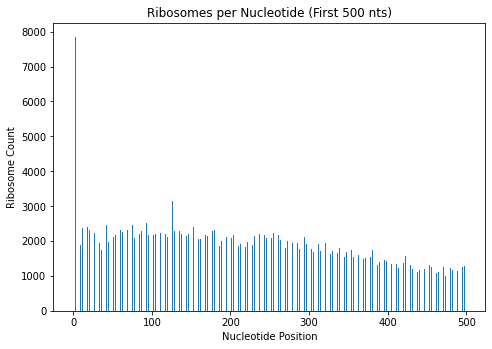

In [9]:
nt500 = aggregate_ribosome_counts[0:500]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([i for i in range(len(nt500))],nt500)
ax.set_title("Ribosomes per Nucleotide (First 500 nts)")
ax.set_xlabel("Nucleotide Position")
ax.set_ylabel("Ribosome Count")
plt.show()

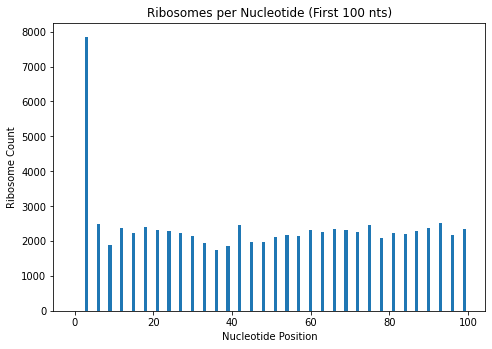

In [10]:
nt100 = aggregate_ribosome_counts[0:100]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([i for i in range(len(nt100))],nt100)
ax.set_title("Ribosomes per Nucleotide (First 100 nts)")
ax.set_xlabel("Nucleotide Position")
ax.set_ylabel("Ribosome Count")
plt.show()

## 3.3

Lastly, create a histogram of the number of ribosomes in each gene, as well as a histogram for the density of ribosomes for each gene (the density is the #ribosomes/length). Make sure to log transform the ribosome counts and densities before plotting the histogram.

### Ribosomes per Gene

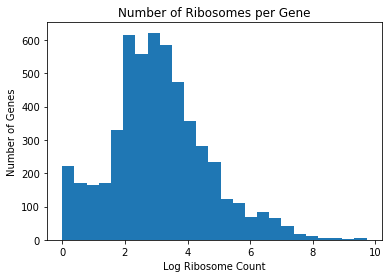

In [11]:
num_ribosomes_list = list(num_ribosomes.values())
log_ribosome_counts = num_ribosomes_list.copy()
for i in range(len(num_ribosomes.values())):
    if num_ribosomes_list[i] == 0: 
        log_ribosome_counts[i] = 0
    else:
        log_ribosome_counts[i] = math.log(num_ribosomes_list[i])
    
plt.hist(log_ribosome_counts, 25)
plt.xlabel("Log Ribosome Count")
plt.ylabel("Number of Genes")
plt.title("Number of Ribosomes per Gene")
plt.show()

#### Densities by Gene

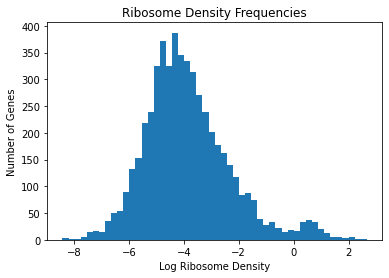

In [12]:
ribosomes_density = {}
for gene in gene_coverage_dict:
    ribosomes_density[gene] = sum(gene_coverage_dict[gene]) / len(gene_coverage_dict[gene])
densities_list = list(ribosomes_density.values())

densities_list = list(ribosomes_density.values())
log_densities = densities_list.copy()
for i in range(len(densities_list)):
    if densities_list[i] == 0: 
        log_densities[i] = 0
    else:
        log_densities[i] = math.log(densities_list[i])
    
plt.hist(log_densities, 50)
plt.xlabel("Log Ribosome Density")
plt.ylabel("Number of Genes")
plt.title("Ribosome Density Frequencies")
plt.show()

## 3.4

Do you notice any patterns in the number of ribosomes and ribosome position along the sequence? What might this represent biologically?

### 3.4 Answer



Looking at the ribosome position charts (and upon further inspection), I noticed that ribosomes are only present at positions that are divisible by 3 (i.e. third nucleotide, sixth nucleotide, etc.). I believe that this would happen because the ribosome is only binding to the end of a codon, rather than in the middle or beginning. This would make sense for consistency of translation without frame shifting. 

Additionally, there are a far higher number of ribosomes at position three than at other positions. I would hypothesize that this happens because there is a delay from when the ribosome binds the first codon of an mRNA to when it starts actively translating. If this logic is correct, it appears that the ribosome translates the rest of the mRNA at a relatively constant speed.